# Кластеризация и прогнозирование оттока клиентов <br>сети фитнес-центров «Культурист дата-саентист» 

## 1. Обзор данных

**Импорты**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
#pip install -U seaborn

**Фреймы**

In [3]:
df = pd.read_csv('gym_churn.csv')

**Обзор**

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
#небольшая предобработка
df.columns = df.columns.str.lower()

In [7]:
#и сразу дубликаты посмотрим
print('Дубликатов в таблице:', df.duplicated().sum())

Дубликатов в таблице: 0


**Резюме по имеющимся данным**
- 4000 наблюдений
- 13 признаков и 1 целевая переменная
- Пропусков нет
- Дубликатов нет
- Категориальных переменных без числовых значений нет

## 2. EDA: Исследовательский анализ данных

**Средние значения по всем клиентам**

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Наблюдения по данным:**
- Мужчин и женщин поровну
- 85% клиентов живут или работают рядом с фитнес-клубом
- Половина клиентов - сотрудники компании-партнёра клуба
- По акции "Приведи друга" пришло 30% клиентов
- Подавляющая часть клиентов (90%) оставляет номер
- Средняя длительность абонимента - 4.6 месяцев (то есть 3 или 6 месяцев)
- 41% клиентов хоть раз посещал групповые программы
- Средний возраст - 29 лет, а самому старшему клиенту 41 год
- Средний лайфтайм - около 4 месяцев
- Клуб в среднем посещают 2 раза в неделю (стандартное отклонение - 1 день): то есть от 1 до 3 дней. Частота посещений в неделю за последний месяц отличается не сильно. 
- Клиенты тратят на другие услуги фитнес-центра в среднем 150 у.е.
- 26% всех клиентов (из данной таблицы) перестали ходить в текущем месяце

**Средние значения по двум отдельным группам**

Смотрим значения признаков в двух группах: тех, кто ушел в отток и тех, кто остался

In [9]:
df.groupby('churn') \
    .mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Наблюдения по данным:**
- Клиенты, котрые остаются, немного чаще являются сотрудниками компаний-партнёров клуба
- Равно как и те, кто пришли по акции "Приведи друга"
- Очень показательная (и кажется очень логичная) ситуация с периодом абонимента. У тех, кто остается, он в среднем на 5 месяцев больше (длиннее). Столбец "month_to_end_contract" показывает то же самое. Есть ощущение, что он будет сильно скоррелирован со столбцом "contract_period". 
- Групповые занятия посещает почти в два раза больше тех, кто остается. (Тоже вполне логично: это показывает вовлечение в спорт. Пошел на допы, значит заинтересован.
- Те, кто уходят, в среднем на 3 года моложе
- Эту же мысль отчасти подтверждает и столбец "avg_additional_charges_total". Клиенты, которые остались, тратили на 40 у.е. больше на дополнительные услуги: тоже показатель вовлеченности. 
- Очень показательно работает столбец "lifetime". У тех, кто покидает, среднее время с момента первого обращения - 1 месяц. То есть, скорее всего, они решили попробовать, купили абонимент на месяц, сходили пару раз и забросили. Как раз у нас данные на месяц до оттока. 
- Те, кто остался, посещали зал чаще, чем те, кто ушел. В последнем месяце это разница ровно в 1 посещение в неделю.


**Предварительное предположение**

Клиенты, которые уходят, в среднем:
- Покупают короткие абонименты (на месяц)
- Меньше тратят на доп.услуги
- Реже посещают групповые занятия
- Первый раз пришли в клуб месяц назад
- Ходят 1 - 1.5 раза в неделю
- Чаще (но не сильно чаще) всего пришли не из компании-партнера и не по рекомендации друга

**Клиенты, которые остались. Распределение признаков**

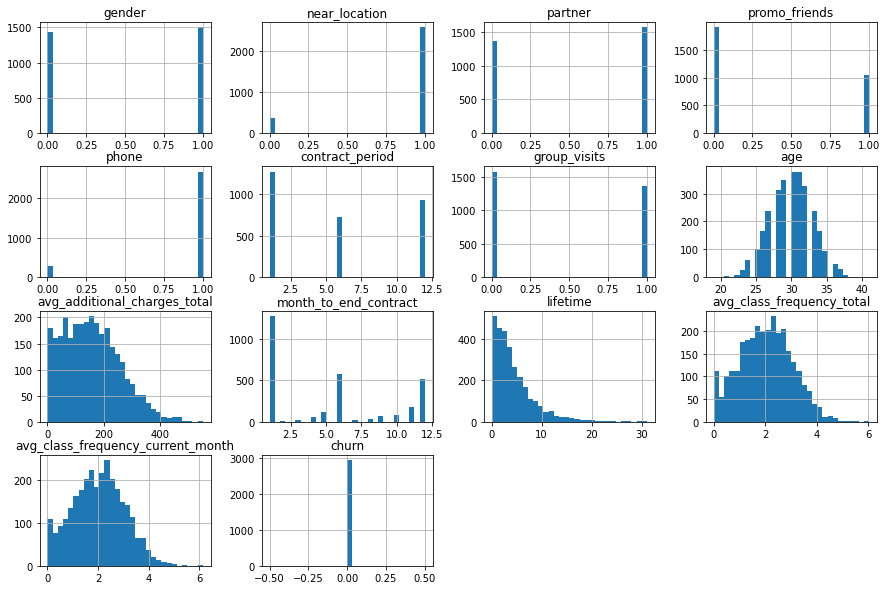

In [10]:
df.query('churn == 0').hist(bins=30, figsize=(15,10))
pass

**Клиенты, которые ушли. Распределение признаков**

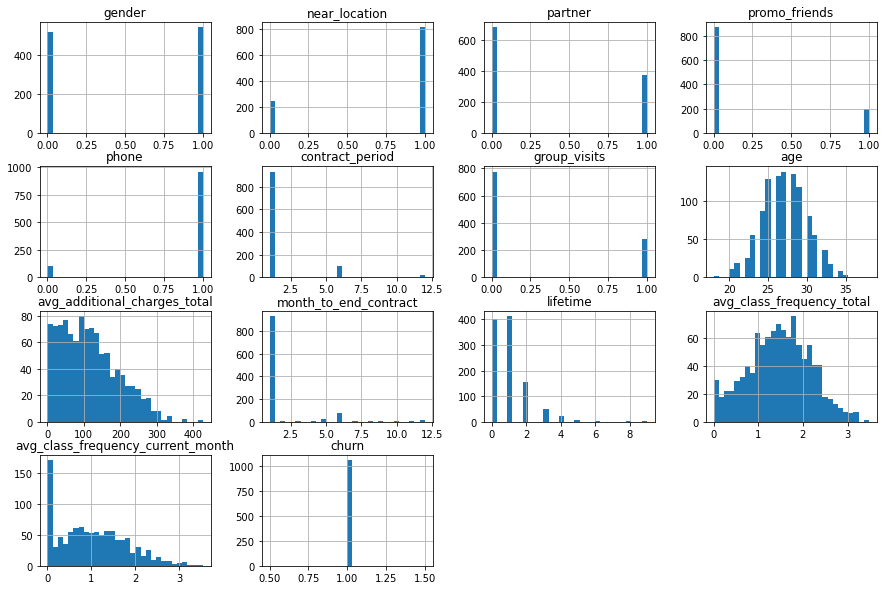

In [11]:
df.query('churn == 1').hist(bins=30, figsize=(15,10))
pass

- Гистограммы хорошо показывают разницу между группами в количестве посещений за последний месяц, длительности абонимента и лайфтайме
- Особых выбросов (или намеков на них), способных исказить данные, не замечается 

**Матрица корреляций**

In [12]:
df_corr_matrix = df.corr()

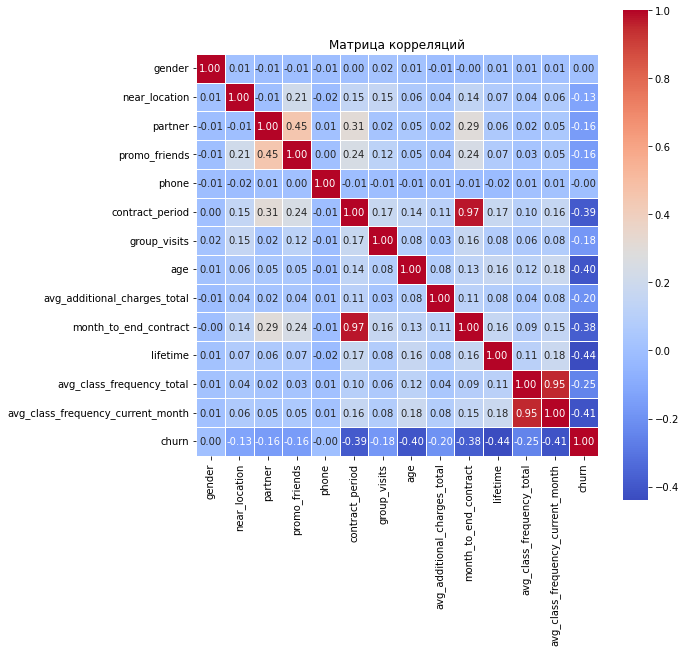

In [13]:
fig, ax = plt.subplots(figsize=(9,9))
plt.title('Матрица корреляций')
sns.heatmap(df_corr_matrix, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt='.2f')
pass

**Выводы по матрице:**
- Как и предполагал, есть две очень скоррелированных признака:
    - month_to_end_contract и contract_period
    - avg_class_frequency_total	и avg_class_frequency_current_month
- 0.45 корреляции между статусами "Пришел из компании партнера" и "Пришел по рекомендации друга". Может быть коллеги советуют ходить?
- С целевой переменной оттока в большей степени коррелируют признаки (не беря в рассчет один из скоррелированных):
    - contract_period (0.39)
    - age (0.4), хотя по таблице средних разница была всего в 3 года
    - lifetime (0.44)
    - avg_class_frequency_current_month (0.41)
- Возраст и признак "Оставил телефон или нет" сами по себе не влияют на факт оттока от слова совсем.

## Создаем модель прогнозирования оттока клиентов

**Избавимся от скоррелированных столбцов**

In [14]:
df_for_model = df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

**Делим данные на две выборки**

In [15]:
X = df_for_model.drop('churn', axis=1)
y = df_for_model.churn

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50, test_size=0.2)

**Обучаем модели**

Логистическая регрессия

In [17]:
lr_model = LogisticRegression(random_state = 50)

In [18]:
lr_model.fit(X_train, y_train)
pass

Случайный лес

In [19]:
#теперь случайный лес
rf_model = RandomForestClassifier(random_state = 50)

In [20]:
rf_model.fit(X_train, y_train)
pass

**Делаем предсказания**

In [21]:
#логист.регрессия
lr_predictions = lr_model.predict(X_test)

In [22]:
#случайный лес
rf_predictions = rf_model.predict(X_test)

**Оцениваем метрики**

In [23]:
print('Оценки для модели Логистической регрессии')

# отношение количества правильных прогнозов к их общему количеству.
print('Accuracy (Доля правильных): {:.3f}'.format(accuracy_score(y_test, lr_predictions)))

# доля объектов, названных классификатором положительными, и при этом действительно являющимися положительными
# как много наблюдений, из тех что классификатор назвал оттоком, действительно являются оттоком
print('Precision (Точность): {:.3f}'.format(precision_score(y_test, lr_predictions)))

# доля наблюдений, которые классификатор назвал положительными из всех, что действительно такими являлись
print('Recall (Полнота): {:.3f}'.format(recall_score(y_test, lr_predictions)))

# балансирует точность и полноту
print('F1-мера: {:.3f}'.format(f1_score(y_test, lr_predictions)))

Оценки для модели Логистической регрессии
Accuracy (Доля правильных): 0.905
Precision (Точность): 0.802
Recall (Полнота): 0.848
F1-мера: 0.824


In [24]:
print('Оценки для модели Случайного леса')

# отношение количества правильных прогнозов к их общему количеству.
print('Accuracy (Доля правильных): {:.3f}'.format(accuracy_score(y_test, rf_predictions)))

# доля объектов, названных классификатором положительными, и при этом действительно являющимися положительными
# как много наблюдений, из тех что классификатор назвал оттоком, действительно являются оттоком
print('Precision (Точность): {:.3f}'.format(precision_score(y_test, rf_predictions)))

# доля наблюдений, которые классификатор назвал положительными из всех, что действительно такими являлись
print('Recall (полнота): {:.3f}'.format(recall_score(y_test, rf_predictions)))

# балансирует точность и полноту
print('F1-мера: {:.3f}'.format(f1_score(y_test, rf_predictions)))

Оценки для модели Случайного леса
Accuracy (Доля правильных): 0.900
Precision (Точность): 0.801
Recall (полнота): 0.824
F1-мера: 0.812


**Выводы по оценкам**

- Модели показывают схожие оценки
- На долю правильных ответов можно особо не смотреть: классы не сбалансированы
- Логистическая регрессия показывает чуть лучший recall
- Случайный лес - чуть лучший precision
- Объединяющая recall и precision f1-мера практически одинаковая

**Что важнее для нас в модели?**

- Чем выше precision, тем меньше ложно позитивных предсказаний - то есть тем меньше ситуаций, когда модель предсказала клиенту отток, хотя он и не собирался уходить.
- Чем выше recall, тем меньше ложно негативных предсказаний - то есть тем меньше ситуаций, когда модель предсказала, что клиент не собирается уходить, а он все таки ушел.

Дальше все зависит от наших ресурсов и тех мер, которые мы готовы предпринять. 
1. Если мы вкладываем в удеражние каждого клиента не так много ресурса (условно, просто организовываем массовую e-mail рассылку), то лучше взять модель с большим recall, то есть - Логистическую регрессию. В таком случае мы рискуем чуть чаще отправлять такие письма клиентам, которые и не собирались уходить. Но это не страшно, нам это почти ничего не стоит.

2. Если же для удержания мы проводим большую индивидуальную работу (предлагаем индивидуальные условия, скидку, доп.услуги), то лучше взять модель с большим precision, то есть - Случайный лес. Да, модель будет показывать больше ложно-негативных предсказаний, зато мы с меньшей вероятностью потратим ресурс на тех, кто и уходить особо не собирался. 

**Важность признаков**

Посмотрим на признаки, которые в наибольшей степени влияют на отток клиентов. 
Поскольку мы не стандартизировали признаки, то смотреть их коэффициенты для модели Логистической регрессии бессмысленно. Они не покажут нам реальную силу. Поэтому посмотрим на значения важности признаков в модели Случайного леса. Они приведены к виду, когда в сумме дают единицу.

In [25]:
features_dict = {'feature': X.columns, 'importance_level': rf_model.feature_importances_}
features_df = pd.DataFrame(data=features_dict).sort_values(by='importance_level', ascending=False)

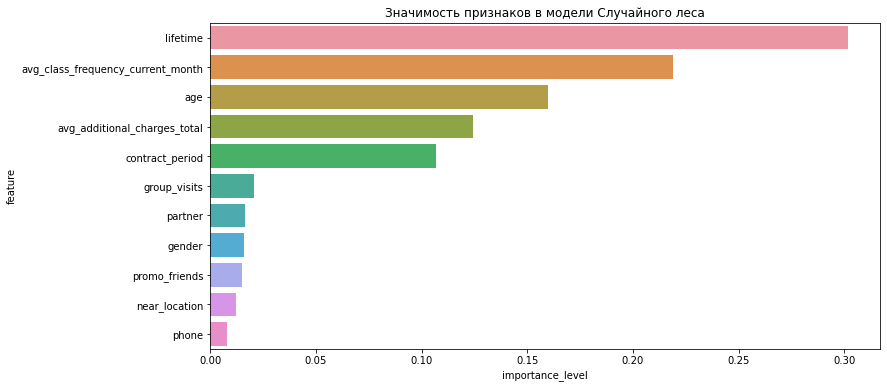

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title('Значимость признаков в модели Случайного леса')
sns.barplot(data=features_df, y='feature', x='importance_level', orient='h')
pass

График подтверждает предварительные наблюдения из матрицы корреляций. Модель Случайного леса считает самыми важными признаками для оценки оттока:

- Лайфтайм (время с момента первого обращения) - причем с большим отрывом
- Частоту посещений в последний месяц
- Возраст (и это слегка неожиданно)
- Траты на дополнительные услуги
- Период текущего абонимента

## Кластеризация клиентов

Теперь попробуем узнать чуть побольше о самих клиентах и разделить их на несколько целевых групп. 

**Стандартизируем данные**

In [27]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

**Матрица расстояний и дендрограмма**

In [28]:
linked = linkage(X_st, method = 'ward')

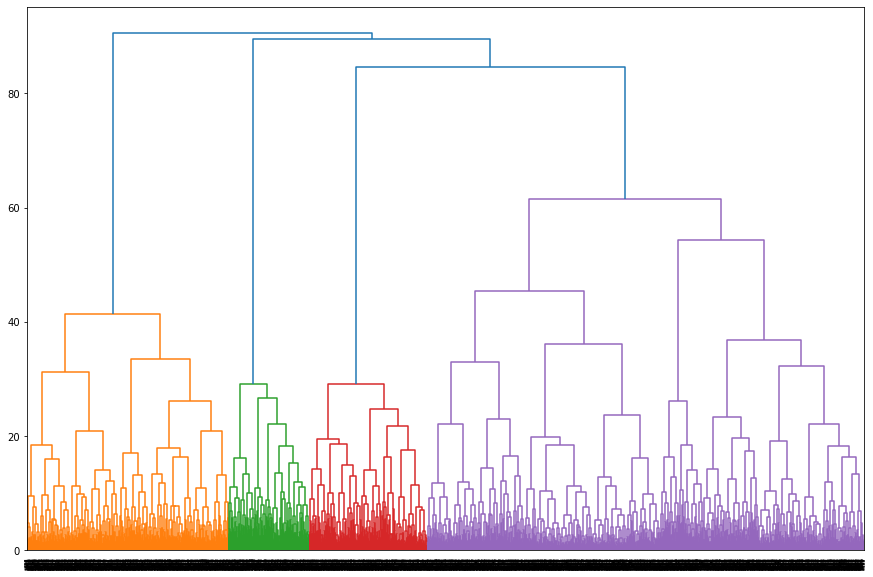

In [29]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

График показывает группы 4-х цветов, но хорошо видно, что фиолетовая группа состоит из двух больших подгрупп. Каждая из подгрупп по размеру даже превосходит другие целые группы. Предлагаю все таки выделять 5 кластеров. 

**Строим модель по алгоритму K-Means**

In [30]:
km_model = KMeans(n_clusters = 5, random_state=50)
clusters = km_model.fit_predict(X_st)

**Средние значения каждого кластера**

In [31]:
#добавим в исходный фрейм отдельный столбец с номером кластера для каждого клиента
df['cluster'] = clusters

In [32]:
df.cluster.value_counts()

4    1066
0    1003
2     987
1     558
3     386
Name: cluster, dtype: int64

Самые многочисленный кластер - 4. Самый маленький - 3.

In [33]:
#посмотрим на средние значения признаков каждого кластера
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.544367,0.500000,0.496454,0.523316,0.491557
near_location,0.996012,0.000000,0.995947,0.862694,1.000000
partner,0.380857,0.489247,0.890578,0.471503,0.216698
promo_friends,0.009970,0.078853,1.000000,0.305699,0.070356
phone,1.000000,1.000000,1.000000,0.000000,1.000000
contract_period,6.203390,2.994624,6.910841,4.777202,2.032833
group_visits,0.525424,0.232975,0.523810,0.427461,0.290807
age,30.640080,28.679211,29.600811,29.297927,27.651970
avg_additional_charges_total,178.037296,137.125763,153.546885,144.208179,117.703748
month_to_end_contract,5.645065,2.818996,6.322188,4.466321,1.962477


Что характерного можно сразу заметить по средним значениям каждого кластера:
1. В кластере "3" никто не оставил своего номера телефона.
2. В кластере "1" судя по всему находятся клиенты, которые не живут и не работают в районе фитнес-центра. 
3. В кластере "2" все клиенты пришли по приглашению друга.
4. Кластеры разделились по признаку "lifetime": 2 мес., 3 мес., 4.мес, 4.2 мес, 5.5 мес.
6. Похоже, что в 0 кластере собрались самые надежные клиенты - там доля оттока всего-лишь чуть больше 1%.
7. Самый "гулящий" - кластер номер 4. Процент оттока - 56%. 
8. Группа с наименьшим оттоком самая взрослая, а группа с наибольшим оттоком - самая молодая. 

Значения в целом сходятся с теми параметрами важности признаков, что показала модель бинарной классификации. 

### Распределения признаков по кластерам

**Кластер 0 - Самые лояльные**
1. Наименьшая доля оттока - всего 1.16%
2. Берут больше абониментов длительностью на год, чем абониментов на месяц. 
3. Никто из них при этом не пришел по рекомендации друга. 
4. Чаще всех ходят в зал, больше всех тратят на допы
5. Средний возраст самый высокий. 

Этот кластер - самые молодцы. 

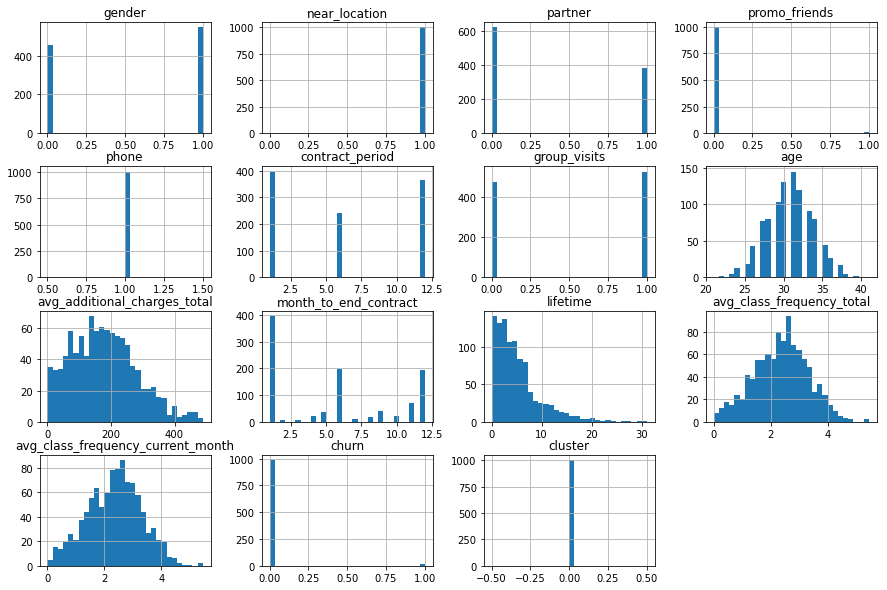

In [34]:
df.query('cluster == 0').hist(bins=30, figsize=(15, 10))
pass

**Кластер 1 - Далекоживущие**
1. Никто из клиентов кластера не живет и не работает в районе фитнес-центра.
2. Лишь небольшая доля пришла по рекомендации друзей. 
3. Чаще всего берут абонимет на месяц
4. Второе место по оттоку клиентов среди всех кластеров 

(!) Сюда нужно обратить внимание: этот кластер кажется требует работы. 

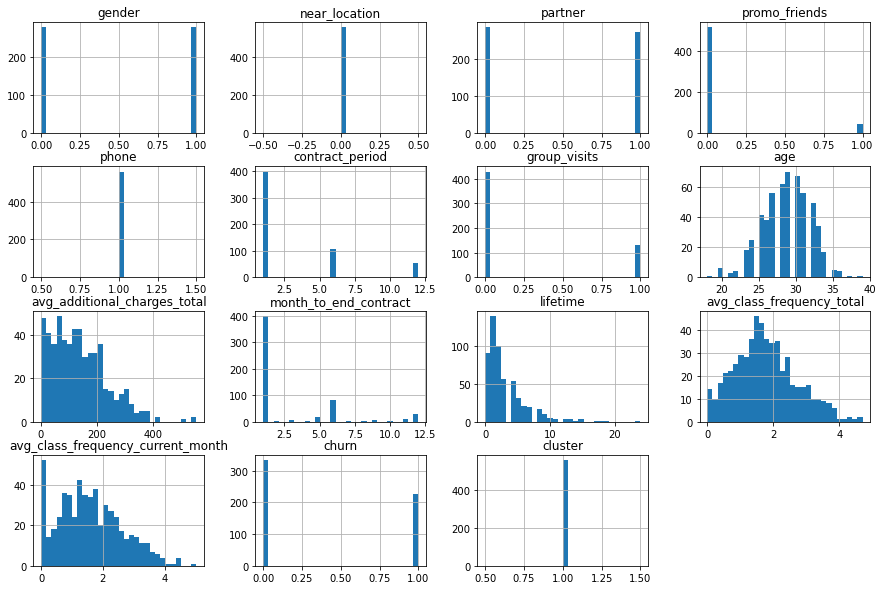

In [35]:
df.query('cluster == 1').hist(bins=30, figsize=(15, 10))
pass

**Кластер 2 - Коллеги**
1. Все клиенты пришли по приглашению друга и практически все - по партнерской программе. Ощущение, что этот кластер можно назвать "коллеги". 
2. Отток у наших "коллег" достаточно небольшой
3. У этого кластера самый высокий средний период купленного абонимента. На графике распределений видно, как много у них годовых абониментов.
4. Достаточно много тратят на доп.услуги.

Хороший лояльный кластер - молодцы. Оставим их в покое. 

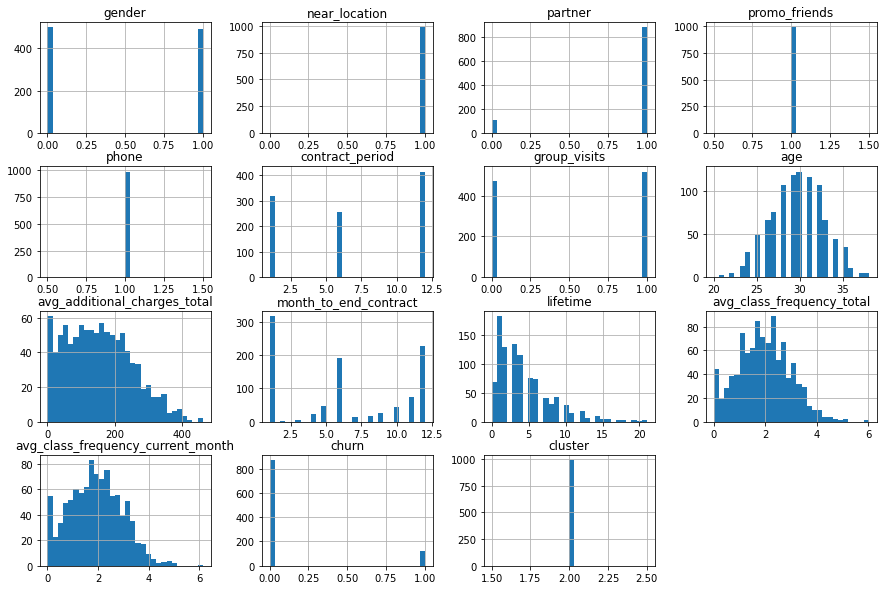

In [36]:
df.query('cluster == 2').hist(bins=30, figsize=(15, 10))
pass

**Кластер 3 - Среднячки**

В этом кластере никто из клиентов не оставил своего номера телефона. И видимо это единственный признак, по которому их отделил алгоритм. Здесь все показатели - средненькие. Средненько тратят, берут средненькие по длительности абонименты, средненько ходят на тренировки. Наблюдаем за ними, но никаких действий по ним я бы по ним не предпринимал. 

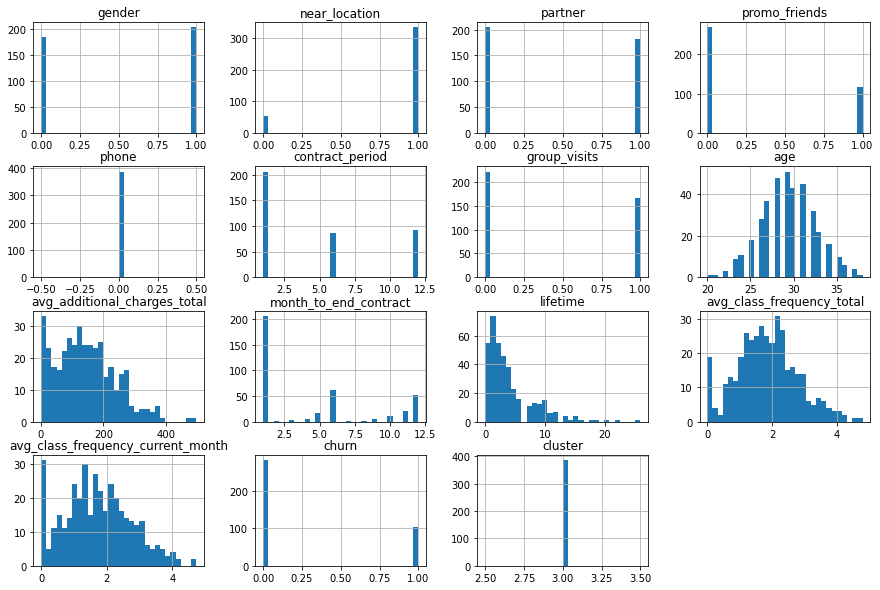

In [37]:
df.query('cluster == 3').hist(bins=30, figsize=(15, 10))
pass

**Кластер 4 - Самые нелояльные**
1. Наибольшая доля оттока - 53%
2. Чаще всего пришли не по приглашению друга, и не по партнерской программе. Грубо говоря - одиночки. 
3. Чаще всего берут абонимент на месяц
4. При этом у каждого из них спортзал находится "под рукой" - в районе проживания или работы. Вот же ленивцы, а!
5. Это самый большой по численности кластер

(!!!) Этот кластер - первый объект внимания для нас. 

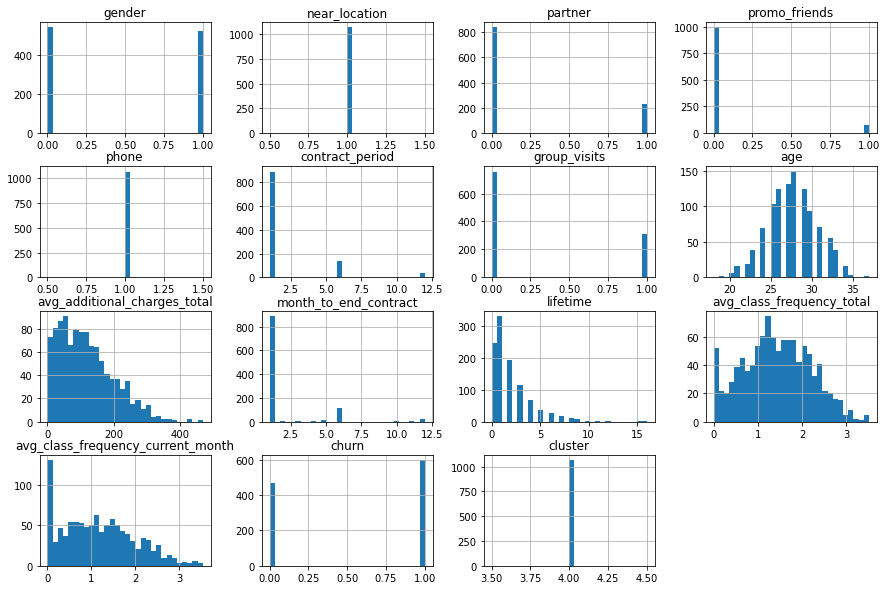

In [38]:
df.query('cluster == 4').hist(bins=30, figsize=(15, 10))
pass

## Выводы 

**Что сделали**

В данной работе мы прогнозировали вероятность оттока клиентов фитнес-центра и занимались их кластеризацией.
- Обучили две модели бинарной классификации (Логистическую регрессию и Случайный лес) и вычисили их метрики
- Научились прогнозировать вероятность оттока для каждого клиента в следующий месяц
- Нашли основные признаки, наиболее сильно влияющие на отток
- Обучили модель кластеризации KMeans с ограничением на 5 кластеров
- Сформировали типичные портреты клиентов


**Признаки, влияющие на отток (в порядке уменьшения важности):**

- Лайфтайм
- Частота посещений в последний месяц
- Возраст 
- Траты на дополнительные услуги
- Период текущего абонимента

**Портрет клиента, который скоро от нас уйдет**

- Покупает абонимент на месяц (contract_period)
- 1 раз в неделю посещает зал (avg_class_frequency_current_month)
- Тратит на дополнительные услуги меньше 115-120 у.е. (avg_additional_charges_total)
- Скорее всего пришёл не по рекомендации друга (promo_friends)
- И скорее всего - не по партнерской программе (partner)
- В среднем моложе остальных (age)

**Предложения по взаимодействию с клиентами**

1. Снизить продажу абониментов длительностью на месяц для новых клиентов. Возможно, предложить более выгодные условия на более длительные абонименты при первой покупке. 
2. Следить за параметрами: возраст, частота посещения, траты на доп.услуги. Если они принимают определенные значения, то это знак, что клиент скоро может уйти и пора выйти к нему с коммуникацией (предложением). 
3. Неплохо работает партнерская программа и акция "Приведи друга". Допускаю такую логику: люди, пришедшие по этим программам, скорее всего посещают зал с друзьями и коллегами, а это куда веселее, чем одному. Возможное предложение - расширить эту программу (больше компаний-партеров, более высокий бенефит за приведенного друга).

